# Breast Cancer Detection using CNN
# Dataset: Breast Histopathology Images (IDC dataset)

This project uses a deep learning pipeline to classify breast histopathology images (benign vs malignant). We preprocess images, build and train a convolutional neural network, and evaluate performance using accuracy, loss curves, and a confusion matrix — demonstrating that deep learning can effectively aid early cancer detection

Histopathology - the study of diseased tissues and cells under a microscope to for diagnosing many solid-tumor cancers and is used for a wide range of other diseases

In [1]:
# On Linux-based notebook environment (including Colab)
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   39G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  750M  62% /usr/sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        73G   40G   34G  54% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
# --- Step 1: Install and Import Dependencies ---
!pip install tensorflow keras matplotlib opencv-python seaborn tqdm --quiet

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# --- Step 2: Mount Google Drive (for saving and accessing files) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Step 3: Download and Unzip Dataset from Google Drive File ID ---
file_id = "1yOpZEUJhT8nmIr2mtjT-aY1v3ScYg5T_"
zip_path = "/content/breast_dataset.zip"
extract_path = "/content/Breast_Histopathology"

# Download ZIP file from Google Drive using gdown
!gdown --id {file_id} -O {zip_path}

# Unzip dataset quietly into /contentA
!unzip -q {zip_path} -d {extract_path}

print("Dataset extracted successfully at:", extract_path)

# Update dataset path for further use
dataset_dir = dataset_dir = "/content/Breast_Histopathology/IDC_regular_ps50_idx5"
print("Dataset directory set to:", dataset_dir)

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yOpZEUJhT8nmIr2mtjT-aY1v3ScYg5T_
From (redirected): https://drive.google.com/uc?id=1yOpZEUJhT8nmIr2mtjT-aY1v3ScYg5T_&confirm=t&uuid=4b061e9b-9081-4622-bf0c-90a1472865fe
To: /content/breast_dataset.zip
100% 3.33G/3.33G [00:45<00:00, 73.1MB/s]
Dataset extracted successfully at: /content/Breast_Histopathology
Dataset directory set to: /content/Breast_Histopathology/IDC_regular_ps50_idx5


In [ ]:
!ls /content/Breast_Histopathology/IDC_regular_ps50_idx5/10253

0  1


In [ ]:
# --- Step 4 + Step 5: Load Data for IDC Dataset (Memory-Safe Version) ---

import os
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE =  64          # smaller images = less RAM (64 is fine if you have more memory)
MAX_IMAGES = 20000      # total images to load (adjust as per your runtime capacity)

data = []
labels = []

benign_count = 0
malignant_count = 0
count = 0

# Loop through each patient folder
for patient_folder in tqdm(os.listdir(dataset_dir), desc="Patients"):
    patient_path = os.path.join(dataset_dir, patient_folder)
    if not os.path.isdir(patient_path):
        continue

    # Each patient folder has '0' (benign) and '1' (malignant)
    for label in ["0", "1"]:
        class_path = os.path.join(patient_path, label)
        if not os.path.exists(class_path):
            continue
        class_num = int(label)

        # Loop through images inside this class folder
        for img_file in os.listdir(class_path):
            if count >= MAX_IMAGES:
                break
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(class_num)
                count += 1
            except Exception as e:
                pass

        if count >= MAX_IMAGES:
            break

    if count >= MAX_IMAGES:
        break

# Convert lists to NumPy arrays and normalize
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Count benign / malignant for loaded portion
benign_count = np.sum(labels == 0)
malignant_count = np.sum(labels == 1)

print(f"Loaded {len(data)} images (benign={benign_count}, malignant={malignant_count})")
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Patients:   8%|▊         | 21/279 [00:06<01:19,  3.25it/s]


Loaded 20000 images (benign=14644, malignant=5356)
Data shape: (20000, 64, 64, 3), Labels shape: (20000,)


In [ ]:
# --- Step 6: Split Data into Train and Validation Sets ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 16000, Validation samples: 4000


In [ ]:
# --- Step 7: Data Augmentation ---
# Helps prevent overfitting by adding random transformations
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

**Class Distribution Plot**

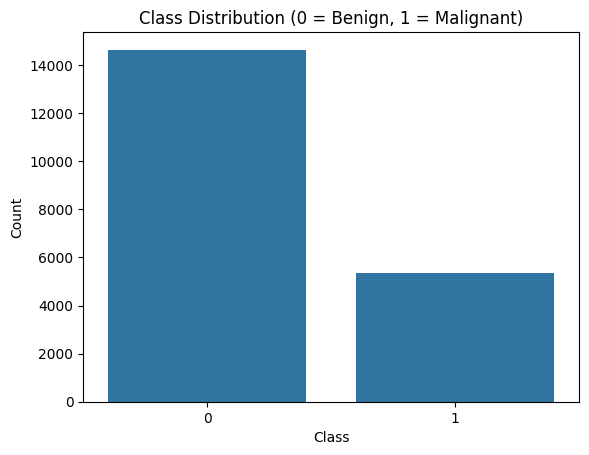

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=labels)
plt.title("Class Distribution (0 = Benign, 1 = Malignant)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Sample Images Grid**

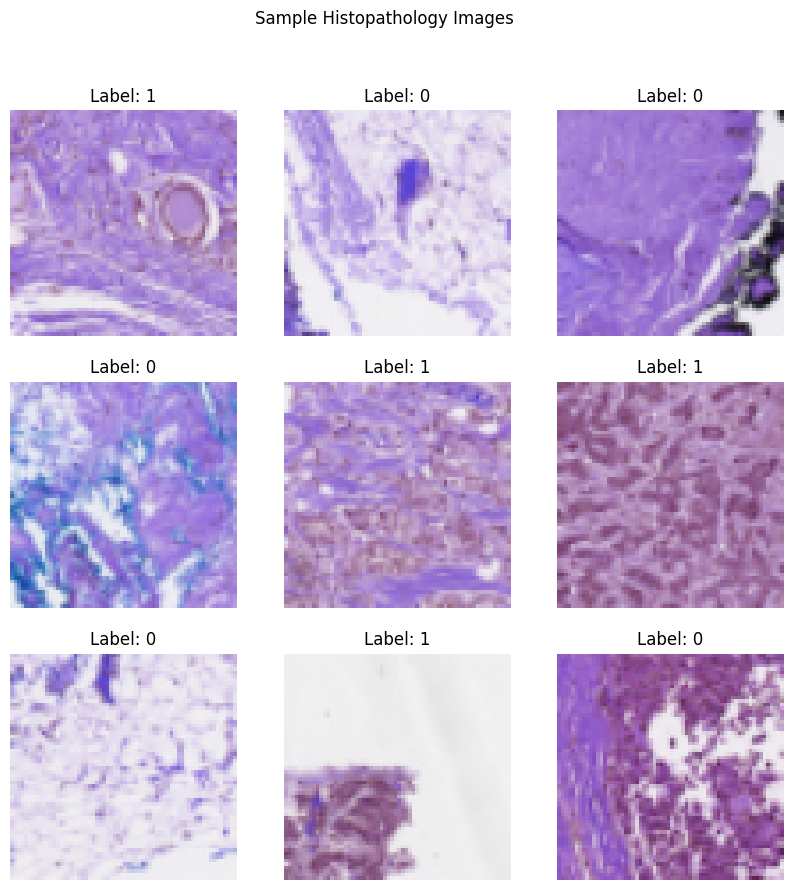

In [ ]:
import random

plt.figure(figsize=(10, 10))
for i in range(9):
    idx = random.randint(0, len(data)-1)
    plt.subplot(3, 3, i+1)
    plt.imshow(data[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")

plt.suptitle("Sample Histopathology Images")
plt.show()

In [ ]:
# --- Step 8: Build CNN Model Architecture ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,305 (4.86 MB)

 Trainable params: 1,273,857 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# --- Step 9: Compile Model ---
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# --- Step 10: Define Callbacks ---
# Save best model and stop early if validation loss stops improving
checkpoint_path = '/content/drive/MyDrive/best_model.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# --- Step 11: Train the Model ---
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_val, y_valzzz),
    callbacks=[checkpoint, early_stop],
    verbose=1
)

print("Training complete. Best model saved to Drive.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 181s 353ms/step - accuracy: 0.8064 - loss: 0.8269 - val_accuracy: 0.8102 - val_loss: 0.4294
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 330ms/step - accuracy: 0.8726 - loss: 0.3207 - val_accuracy: 0.8602 - val_loss: 0.5363
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 170s 340ms/step - accuracy: 0.8830 - loss: 0.2937 - val_accuracy: 0.8380 - val_loss: 0.9953
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 173s 346ms/step - accuracy: 0.8937 - loss: 0.2720 - val_accuracy: 0.8410 - val_loss: 0.6913
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 200s 343ms/step - accuracy: 0.8944 - loss: 0.2703 - val_accuracy: 0.7487 - val_loss: 0.4725
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 174s 347ms/step - accuracy: 0.8969 - loss: 0.2619 - val_accuracy: 0.7405 - val_loss: 13.8310
Training complete. Best model saved to Drive.


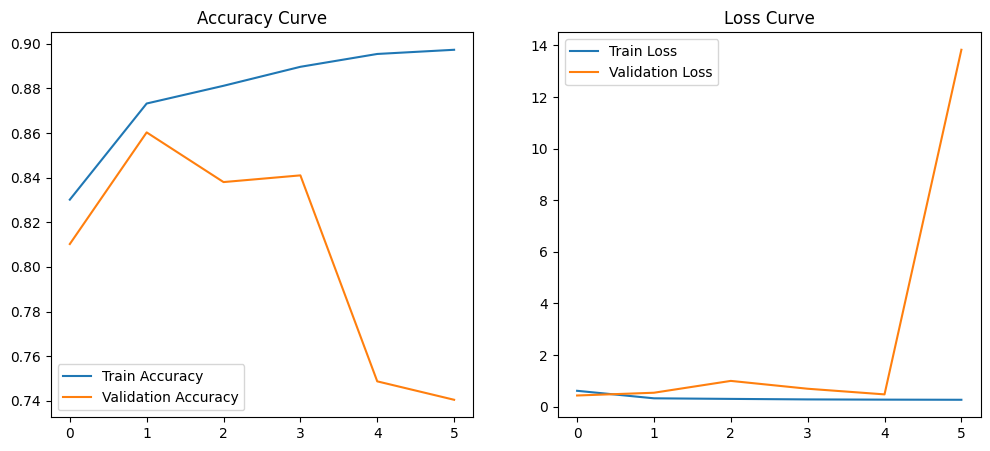

In [ ]:
# --- Step 12: Plot Accuracy and Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()

**Confusion Matrix**

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step


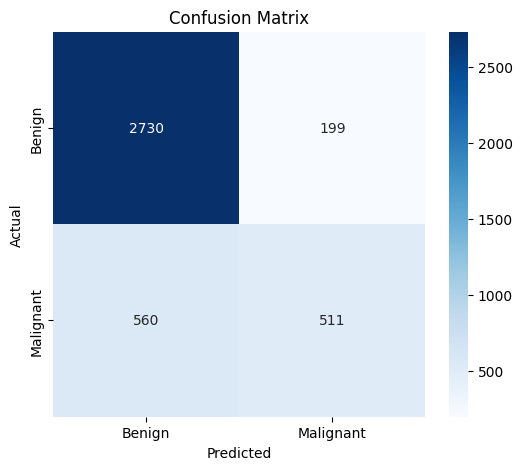

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.83      0.93      0.88      2929
   Malignant       0.72      0.48      0.57      1071

    accuracy                           0.81      4000
   macro avg       0.77      0.70      0.73      4000
weighted avg       0.80      0.81      0.80      4000



In [ ]:
# --- Step 13: Evaluate Model ---
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8091 - loss: 0.4259
Validation Accuracy: 0.8102


In [ ]:
import tensorflow as tf

def rebuild_sequential_as_functional(seq_model):
    """Rebuild Sequential model into a clean Functional one for Grad-CAM."""
    inputs = tf.keras.Input(shape=seq_model.input_shape[1:])
    x = inputs
    for layer in seq_model.layers:
        new_layer = layer.__class__.from_config(layer.get_config())
        x = new_layer(x)
        try:
            new_layer.set_weights(layer.get_weights())
        except:
            pass
    return tf.keras.Model(inputs=inputs, outputs=x)

seq_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.keras')
model = rebuild_sequential_as_functional(seq_model)
print("Functional model rebuilt cleanly for Grad-CAM.")
model.summary()

Functional model rebuilt cleanly for Grad-CAM.


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,305 (4.86 MB)

 Trainable params: 1,273,857 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

# Create Grad-CAM Model

In [ ]:
# --- Prepare Grad-CAM model ---
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

last_conv_layer = model.get_layer(last_conv_layer_name)
print("Using last conv layer:", last_conv_layer.name)

grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[last_conv_layer.output, model.output]
)

Using last conv layer: conv2d_2


# Grad-CAM for ONE Image

Using last conv layer: conv2d_2


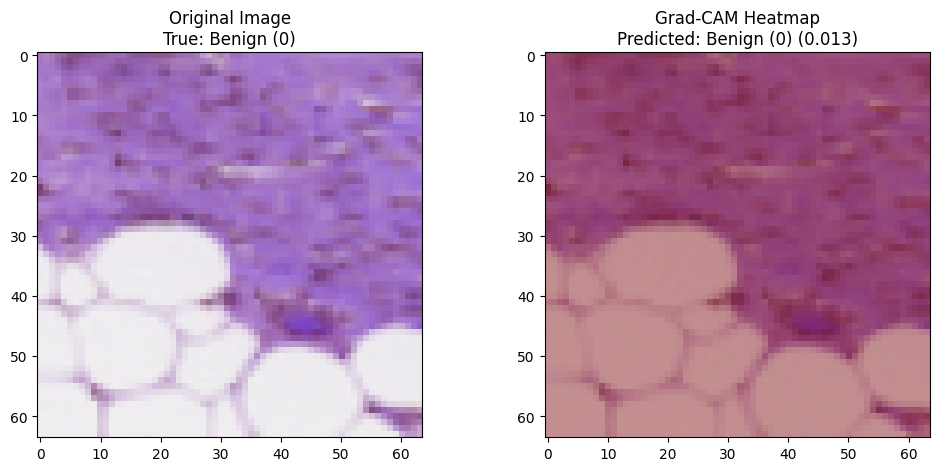

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Pick random validation sample ---
sample_idx = np.random.randint(0, len(X_val))
sample_img = np.expand_dims(X_val[sample_idx], axis=0).astype(np.float32)
img = X_val[sample_idx]
true_label = "Malignant (1)" if y_val[sample_idx] == 1 else "Benign (0)"

# --- Find last Conv2D layer ---
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
last_conv_layer = model.get_layer(last_conv_layer_name)
print("Using last conv layer:", last_conv_layer.name)

# --- Grad-CAM model ---
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[last_conv_layer.output, model.output]
)

# --- Compute Grad-CAM ---
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(sample_img, training=False)
    loss = predictions[:, 0]   # binary sigmoid output

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# --- Generate heatmap ---
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1e-10
# Removed heatmap.numpy() — it's already a NumPy array

# --- Prediction interpretation ---
pred_value = float(predictions.numpy()[0][0])
pred_label = "Malignant (1)" if pred_value >= 0.5 else "Benign (0)"

# --- Overlay heatmap on original image ---
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_colormap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_colormap, 0.4, 0)

# --- Display results ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image\nTrue: {true_label}")

plt.subplot(1, 2, 2)
plt.imshow(superimposed)
plt.title(f"Grad-CAM Heatmap\nPredicted: {pred_label} ({pred_value:.3f})")
plt.show()

# Grad-CAM for 5 Images

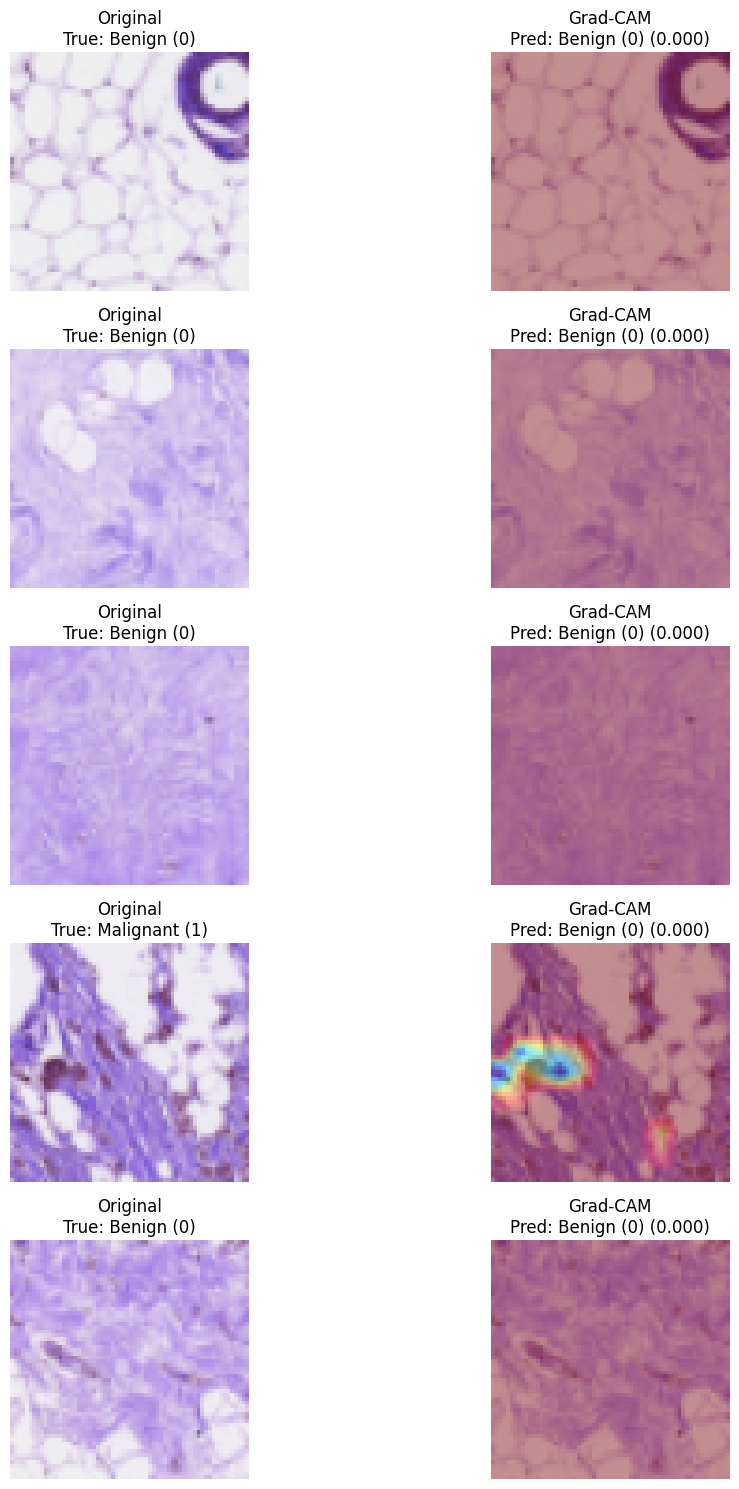

In [ ]:
# --- Grad-CAM for 5 images ---
num_samples = 5
plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    sample_idx = np.random.randint(0, len(X_val))
    sample_img = np.expand_dims(X_val[sample_idx], axis=0).astype(np.float32)
    img = X_val[sample_idx]
    true_label = "Malignant (1)" if y_val[sample_idx] == 1 else "Benign (0)"

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(sample_img, training=False)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1e-10

    pred_value = float(predictions.numpy()[0][0])
    pred_label = "Malignant (1)" if pred_value >= 0.5 else "Benign (0)"

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colormap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_colormap, 0.4, 0)

    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original\nTrue: {true_label}")

    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title(f"Grad-CAM\nPred: {pred_label} ({pred_value:.3f})")

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 15: Save Model Summary and Results to Drive ---
summary_path = "/content/drive/MyDrive/model_summary.txt"
with open(summary_path, "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))
print("Model summary saved to:", summary_path)

Model summary saved to: /content/drive/MyDrive/model_summary.txt
